# Epidemics model - by a physicist

As many nerds at this moment, I turn myself to coding and models, to at least try to spread the key ideas about the dynamics of the currend COVID-19 pandemia. I have come up with a very simple model, where blue balls, representing healty people and red balls, representing sick people interact inside of a square world, infecting each other given a probability of infection. After infection, for each timestep there is a probability of the sick person to die or to recover and gain immunity. 

Please feel free to play with the parameters and check out the evolution of the number of healty, sick, recovered and deceased people in the population. 

Notice that for very small probabilities of cure and death, people are allowed to wander around and spread the infection, leading to an exponential increase in the number of sick people at some point. The peak in the curve of sick people is quite large in comparison to the total population, and it gets there quite fast. Thus, I would say that the main goal of this notebook is to spread the word about how important it is to stay at home (and decrease the mobility parameter).

Next steps are: 

* set up a limit for the health system, which one saturated with sick people, will no longer be able to help people recover, increasing the death probability.
* store an 'age' parameter for each person and collect the mortality rate for each group, taking the model closer to reality
* implement the *severely ill* condition, where mobility is reduced. This reflects the fact that once the person is aware of his or her condition, they stop going around and stay at home or a hospital

## Preamble

Import libraries and declare global variables here. Feel free to play around with the model parameters.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.animation import FFMpegWriter
%matplotlib inline

# global probabilities of infection, dying and being cured
p_infect = 0.7 # <- change this
p_die = 0.005  # <- change this
p_cure = 0.02  # <- change this

# limits of the simulation box and population size
l = 2 # <- change this
xi, xf = -l, l
yi, yf = -l, l
n = 250 # <- change this

# number of steps in dynamics, stepsize and interaction radius
maxiter = 400 # <- change this
dt = 0.1
eps = 0.1

# mobility parameter, it is a measure of social interaction
v0 = 0.5 # <- change this

# filename to be used for both data text and movie files creation
file = 'scenario_C'

def progress_bar(pos, maxpos):
    ''' Função imprime uma barra de progresso na tela, de tamanho máximo maxpos e posição atual pos '''
    print('{:6.2f} % [{:100s}] {:3d}/{:3d}'.format(100 * (pos + 1) / maxpos,
                                                int(100 * (pos + 1) / maxpos) * '#', 
                                                pos + 1,
                                                maxpos))
    clear_output(wait=True)

## Class pessoa

Here I create a class `pessoa` (people in portuguese) where I store all the history of the dynamics in numpy arrays. There is no need to change this.

In [15]:
# a class for a person in the simulation. It encloses the position (x, y),
# velocities (vx, vy), and health state along the time of the simulation
class pessoa:
    def __init__(self, x, y, vx, vy):
        self.x = np.zeros(maxiter, dtype=float)
        self.x[0] = x
        self.y = np.zeros(maxiter, dtype=float)
        self.y[0] = y
        self.vx = np.zeros(maxiter, dtype=float)
        self.vx[0] = vx
        self.vy = np.zeros(maxiter, dtype=float)
        self.vy[0] = vy
        self.health = np.zeros(maxiter, dtype=int)
    
    # scalar velocity of a person
    def get_v(self, step):
        return np.sqrt(self.vx[step] ** 2 + self.vy[step] ** 2)
    
    # angle of interaction. It is used to draw new random velocities 
    # after a social interaction or after bumping in the box edges
    def get_theta(self, p, step):
        return np.arctan((p.y[step] - self.y[step]) / (p.x[step] - self.x[step])) + np.pi
    
    # distance between two people
    def get_dist(self, p, step):
        return np.sqrt((self.x[step] - p.x[step]) ** 2 + (self.y[step] - p.y[step]) ** 2)
    
    # asks if the person is still healty
    def healty(self, step):
        if self.health[step] == 0:
            return True
        else:
            return False
    
    # asks if the person is sick (1) or seriously sick (2)
    def sick(self, step):
        if self.health[step] == 1 or self.health[step] == 2:
            return True
        else:
            return False
    
    # asks if the person acquired immunity after being infected, aka cured
    def cured(self, step):
        if self.health[step] == 3:
            return True
        else:
            return False
    
    # asks if the person did not survive the infection
    def dead(self, step):
        if self.health[step] > 3:
            return True
        else:
            return False

## Start of the model

Initialization of the population in a list and a single person is set sick.

In [22]:
# population is initialized in a single list       
pop = [pessoa(np.random.uniform(xi, xf), 
          np.random.uniform(yi, yf),
          np.random.uniform(-v0, v0),
          np.random.uniform(-v0, v0)) for i in range(n)]

# single infected person in the population at the beginning
pop[0].health[0:] = 1

## Running the dynamics

Here is the core of the thing. Running the dynamics with large populations (> 300) or too many timesteps (> 500) might require more computing power that most people have at home.

In [23]:
# first, summarise the number of healty, sick, cured and dead people for each timestep
nh = np.zeros(maxiter, dtype=int) # healty
ns = np.zeros(maxiter, dtype=int) # sick
nc = np.zeros(maxiter, dtype=int) # cured
nd = np.zeros(maxiter, dtype=int) # dead

# then run the dynamics  
for i in range(maxiter - 1):
    progress_bar(i, maxiter - 1)
    # speed update. There are some distinct situations here
    for j, p in enumerate(pop):
        # first check if the person is still alive
        if (not p.dead(i)):
            v = p.get_v(i)
            
            # (1) two people meed (aka bouncing balls)
            for k, p2 in enumerate(pop[:j] + pop[j + 1:]):
                if p.get_dist(p2, i) < eps and (not p2.dead(i)):
                    q = np.random.normal(p.get_theta(p2, i), np.pi / 6)
                    p.vx[i + 1] = v * np.cos(q)
                    p.vy[i + 1] = v * np.sin(q)  
                    # decide if one infects the other
                    if p.sick(i) and (not p2.sick(i)) and (not p2.cured(i)) and (np.random.uniform() < p_infect):
                        p2.health[i + 1:] = 1

            # (2) person bounce on the left wall of the box
            if p.x[i] < xi + eps:
                t = np.random.normal(0, np.pi / 6)
                p.vx[i + 1] = v * np.cos(t)
                p.vy[i + 1] = v * np.sin(t)
            # (3) bounce on the right wall
            elif p.x[i] > xf - eps:
                t = np.random.normal(np.pi, np.pi / 6)
                p.vx[i + 1] = v * np.cos(t)
                p.vy[i + 1] = v * np.sin(t)
            # (4) bounce on the lower wall
            elif p.y[i] < yi + eps:
                t = np.random.normal(np.pi / 2, np.pi / 6)
                p.vx[i + 1] = v * np.cos(t)
                p.vy[i + 1] = v * np.sin(t)
            # (5) bounce on the upper wall
            elif p.y[i] > yf - eps:
                t = np.random.normal(-np.pi / 2, np.pi / 6)
                p.vx[i + 1] = v * np.cos(t)
                p.vy[i + 1] = v * np.sin(t)
            # (6) does not bounce at all
            else:
                p.vx[i + 1] = p.vx[i]
                p.vy[i + 1] = p.vy[i]

    # update of positions and health status: if person is sick, he or she can die or recover
    for p in pop:
        p.x[i + 1] = p.x[i] + dt * p.vx[i]
        p.y[i + 1] = p.y[i] + dt * p.vy[i]
        # random number in (0, 1) to decide person's fate
        w = np.random.uniform()
        # he or she could die ...
        if p.sick(i) and (w < p_die):
            p.health[i:] = 4
            p.vx[i:], p.vy[i:] = 0.0, 0.0
        # ... or recover
        elif p.sick(i) and (w >= p_die) and (w < p_cure + p_die):
            p.health[i:] = 3
        
        # update the total numbers
        if p.healty(i):
            nh[i] += 1
        elif p.sick(i):
            ns[i] += 1
        elif p.cured(i):
            nc[i] += 1
        elif p.dead(i):
            nd[i] += 1

# and update the numbers for final step 
for p in pop:
    if p.healty(maxiter - 1):
        nh[maxiter - 1] += 1
    elif p.sick(maxiter - 1):
        ns[maxiter - 1] += 1
    elif p.cured(maxiter - 1):
        nc[maxiter - 1] += 1
    elif p.dead(maxiter - 1):
        nd[maxiter - 1] += 1

100.00 % [####################################################################################################] 399/399


## Checking results 1 - write records to file

We can check all records by writing them down to a text file, and see who and when got sick, recovered or died.

In [24]:
# this cell is one way of checking results for each person and each timestep
dict_h = {0 : 'h', 1 : 's', 3 : 'c', 4 : 'd'}

#file into which save the results
datafile = file + '.dat'
with open(datafile, 'w') as f:
    # first the header with the following info: p_infect p_die p_cure l n maxiter dt eps v0
    f.write('{:5.3f} {:5.3f} {:5.3f} {:3d} {:4d} {:4d} {:4.2f} {:4.2f} {:4.2f}\n'.format(p_infect,
                                                                                              p_die,
                                                                                              p_cure,
                                                                                              l,
                                                                                              n,
                                                                                              maxiter,
                                                                                              dt,
                                                                                              eps,
                                                                                              v0))
    # then for each person in population,
    for i, p in enumerate(pop):
        # their number
        f.write('{:3d}\n'.format(i))
        t = ''
        # their x history
        for j in p.x:
            t += '{:6.3f} '.format(j)
        t += '\n'
        # their y history
        for j in p.y:
            t += '{:6.3f} '.format(j)
        t += '\n'
        # their vx history
        for j in p.vx:
            t += '{:6.3f} '.format(j)
        t += '\n'
        # their vy history
        for j in p.vy:
            t += '{:6.3f} '.format(j)
        t += '\n'
        # their health history
        for j in p.health:
            t += '{:1s} '.format(dict_h[j])
        t += '\n'
        f.write(t)

## Checking results 2 - graphically

Next two cells summarize the number of healty, sick, cured and dead people for each timestep and show the graphs of both the dynamics and the headcounts.

In [25]:
# here I show the results graphically
color_dict = {0 : 'blue', 1 : 'red', 3 : 'orange'}

@interact(i=(0, maxiter - 1))

def showme(i):
    fig, ax = plt.subplots(figsize=(14,7), ncols=2, nrows=1)
    # for each person I have to draw the corresponding dot in the first scatter plot
    for p in pop:
        # but not if the person is dead
        if (not p.dead(i)):
            ax[0].scatter(p.x[i], p.y[i], color=color_dict[p.health[i]], s=100)
    ax[0].set_title('step # {:3d}'.format(i))
    ax[0].set_xlim(xi, xf)
    ax[0].set_ylim(yi, yf)
    # clean up axis for better visualisation
    ax[0].tick_params(axis='both',
                which='both',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False)
    
    # the second plot shows how these numbers evolve in time
    ax[1].plot(np.arange(i), nh[:i], lw=2, color='blue', label='{:3d} healty'.format(nh[i]))
    ax[1].plot(np.arange(i), ns[:i], lw=2, color='red', label='{:3d} sick'.format(ns[i]))
    ax[1].plot(np.arange(i), nc[:i], lw=2, color='orange', label='{:3d} cured'.format(nc[i]))
    ax[1].plot(np.arange(i), nd[:i], lw=2, color='black', label='{:3d} dead'.format(nd[i]))
    ax[1].set_xlim(0, maxiter - 1)
    ax[1].set_ylim(0, n)
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('# of people')
    ax[1].legend(loc='upper right')
    
    plt.tight_layout()

interactive(children=(IntSlider(value=199, description='i', max=399), Output()), _dom_classes=('widget-interac…

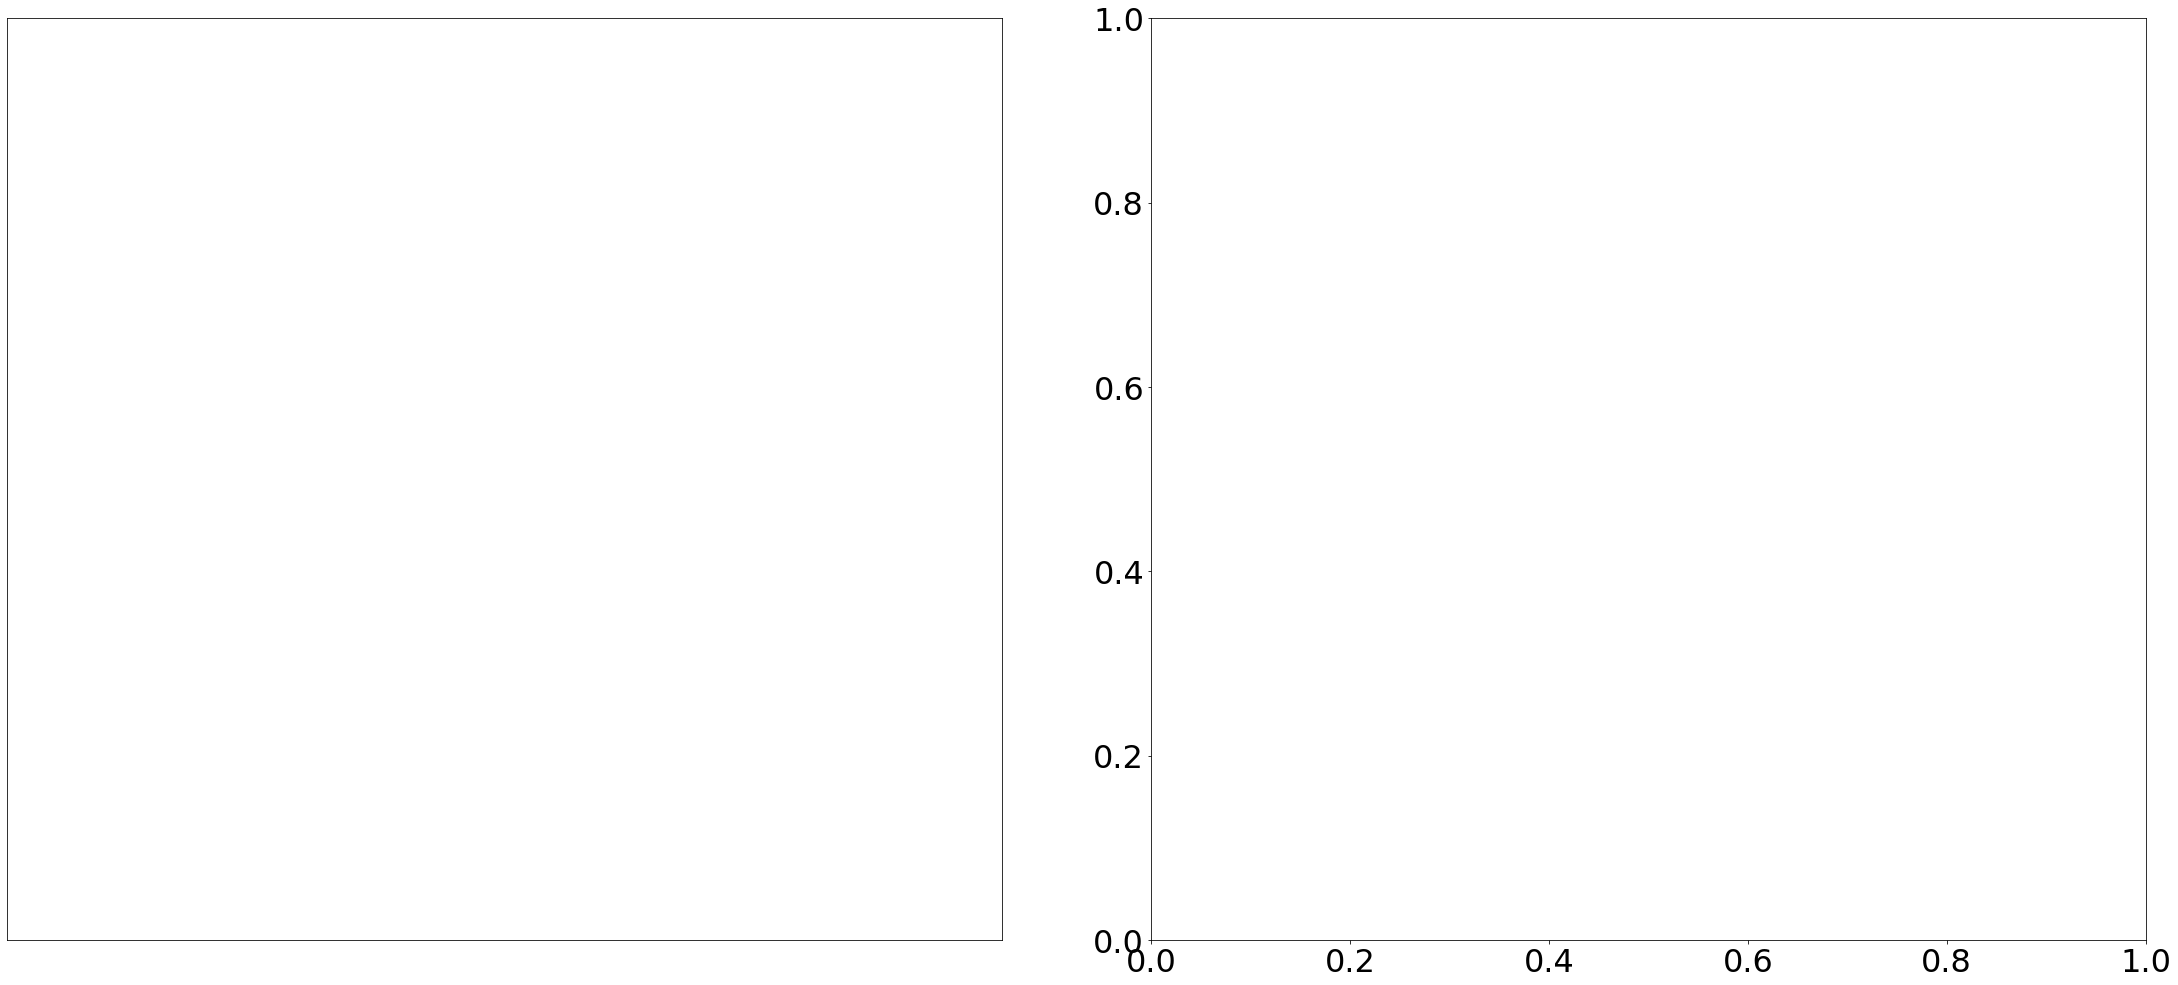

In [26]:
# create movie 
# you should have ffmpeg installed
# I just downloaded the binaries and copied ffmpeg.exe to this project folder

moviefile = file + '.mp4'
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')

writer = FFMpegWriter(fps=12, metadata=metadata)

fig, ax = plt.subplots(figsize=(30,15), ncols=2, nrows=1)

# use writer to write frames to movie file
with writer.saving(fig, moviefile, 100):
    for i in range(maxiter):
        for p in pop:
            # but not if the person is dead
            if (not p.dead(i)):
                ax[0].scatter(p.x[i], p.y[i], color=color_dict[p.health[i]], s=100)
        ax[0].set_title('step # {:3d}'.format(i), fontsize=32)
        ax[0].set_xlim(xi, xf)
        ax[0].set_ylim(yi, yf)
        # clean up axis for better visualisation
        ax[0].tick_params(axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    left=False,
                    right=False,
                    labelbottom=False,
                    labelleft=False)
        ax[0].text(xi + 0.05 * l, yf - 0.05 * l, r'$P_i = ' + '{:5.1f}\%'.format(p_infect * 100) + '$\n' + \
                   r'$P_c = ' + '{:5.1f}\%'.format(p_cure * 100) + '$\n' + \
                   r'$P_d = ' + '{:5.1f}\%'.format(p_die * 100) + '$\n' + \
                   r'$N = ' + '{:4d}'.format(n) + '$\n' + \
                   r'$R_i = ' + '{:4.2f}'.format(eps) + '$\n' + \
                   r'$v_0 = ' + '{:3.1f}'.format(v0) + '$', 
                   fontsize=28,
                    verticalalignment='top',
                  bbox=dict(facecolor='blue', alpha=0.2))        
        
        # the second plot shows how these numbers evolve in time
        ax[1].plot(np.arange(i), nh[:i], lw=4, color='blue', label='{:3d} healty'.format(nh[i]))
        ax[1].plot(np.arange(i), ns[:i], lw=4, color='red', label='{:3d} sick'.format(ns[i]))
        ax[1].plot(np.arange(i), nc[:i], lw=4, color='orange', label='{:3d} cured'.format(nc[i]))
        ax[1].plot(np.arange(i), nd[:i], lw=4, color='black', label='{:3d} dead'.format(nd[i]))
        ax[1].set_xlim(0, maxiter - 1)
        ax[1].set_ylim(0, n)
        ax[1].set_xlabel('steps', fontsize=32)
        ax[1].set_ylabel('# of people', fontsize=32)
        ax[1].legend(loc='upper right', fontsize=32)
        ax[1].tick_params(axis='both',
                which='both',
                labelsize=32)
        plt.tight_layout()
        
        writer.grab_frame()
        # clear axis for next frame
        ax[0].cla()
        ax[1].cla()
        progress_bar(i, maxiter)